In [1]:
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
path2data = './content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [4]:
# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [5]:
# PyTorch에서 제공하는 VOC dataset을 상속받아, custom dataset을 생성합니다.
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기

        targets = [] # 바운딩 박스 좌표
        labels = [] # 바운딩 박스 클래스

        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4])) # 바운딩 박스 좌표
            labels.append(label[4])         # 바운딩 박스 클래스

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [6]:
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)

Using downloaded and verified file: ./content/voc\VOCtrainval_06-Nov-2007.tar
Extracting ./content/voc\VOCtrainval_06-Nov-2007.tar to ./content/voc
Using downloaded and verified file: ./content/voc\VOCtest_06-Nov-2007.tar
Extracting ./content/voc\VOCtest_06-Nov-2007.tar to ./content/voc


In [7]:
# 샘플 이미지 확인
img, target, label = train_ds[2]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8') # 바운딩 박스 색상

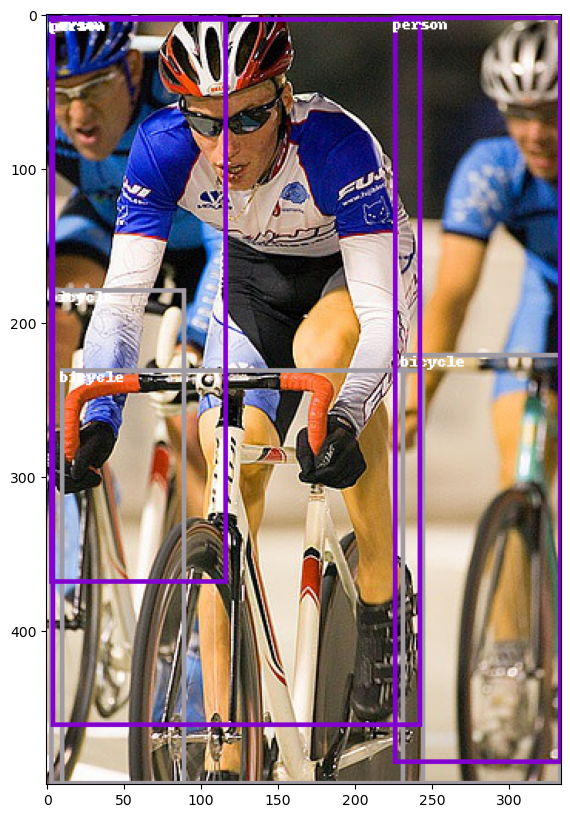

In [8]:
# 시각화 함수
def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg,label in zip(targets,labels):
        id_ = int(label) # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))

plt.figure(figsize=(10,10))
show(img, target, label)

In [9]:
IMAGE_SIZE = 600
scale = 1.0

# 이미지에 padding을 적용하여 종횡비를 유지시키면서 크기가 600x600이 되도록  resize 한다
train_transforms = A.Compose([
    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale),
                  min_width=int(IMAGE_SIZE*scale), border_mode=cv2.BORDER_CONSTANT),
    ToTensorV2()],
                             bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4,
                                                      label_fields=[]))

val_transforms = A.Compose([
    A.LongestMaxSize(max_size=int(IMAGE_SIZE*scale)),
    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[]))

train_ds.transforms = train_transforms
val_ds.transforms = val_transforms

In [10]:
# dataEncoder 정의하기
# 각 피쳐맵에서 모든 cell에 9개의 앵커 박스를 생성
# ground-truth와의 iou를 기준으롤 anchor에 positive, negative를 할당
class DataEncoder:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128., 256*256., 512*512.]
        self.aspect_ratios = [1/2., 1/1., 2/1.]
        self.scale_ratios = [1., pow(2, 1/3.), pow(2, 2/3.)]
        self.anchor_wh = self._get_anchor_wh()
        
    def _get_anchor_wh(self):
        # 각 피쳐맵에서 사용할 앵커 박스 높이와 넓이를 계산합니다.
        anchor_wh = []
        for s in self.anchor_areas:
            for ar in self.aspect_ratios:
                h = math.sqrt(s/ar)
                w = ar * h
                for sr in self.scale_ratios:
                    anchor_h = h*sr
                    anchor_w = w*sr
                    anchor_wh.append([anchor_w, anchor_h])
        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2)

    def _get_anchor_boxes(self, input_size):
        # 피쳐맵의 모든 cell에 앵커 박스 할당
        num_fms = len(self.anchor_areas) # 5
        fm_sizes = [(input_size/pow(2.,i+3)).ceil() for i in range(num_fms)] # 각 피쳐맵 stride 만큼 입력 크기 축소

        boxes = []
        for i in range(num_fms): # p3 ~ p7
            fm_size = fm_sizes[i] # i 번째 피쳐맵 크기 추출
            grid_size = input_size / fm_size # 입력 크기를 피쳐맵 크기로 나누어 grid size 생성
            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            xy = self._meshgrid(fm_w, fm_h) + 0.5 #[fm_h * fm_w, 2] 피쳐맵 cell index 생성
            xy = (xy*grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2) # anchor 박스 좌표
            wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h, fm_w, 9, 2) # anchor 박스 높이와 너비
            box = torch.cat([xy,wh],3) # [x,y,w,h]
            boxes.append(box.view(-1,4))
        return torch.cat(boxes, 0)

    # 피쳐맵의 각 셀에 anchor 박스 생성하고, positive와 negative 할당
    def encode(self, boxes, labels, input_size):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성
        boxes = self._change_box_order(boxes, 'xyxy2xywh') # xyxy -> cxcywh

        ious = self._box_iou(anchor_boxes, boxes, order='xywh') # ground-truth와 anchor의 iou 계산
        max_ious, max_ids = ious.max(1) # 가장 높은 iou를 지닌 앵커 추출
        boxes = boxes[max_ids]

        # 앵커 박스와의 offset 계산
        loc_xy = (boxes[:,:2]-anchor_boxes[:,:2]) / anchor_boxes[:,2:]
        loc_wh = torch.log(boxes[:,2:]/anchor_boxes[:,2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1)

        # class 할당
        cls_targets = 1 + labels[max_ids]
        cls_targets[max_ious<0.5] = 0 # iou < 0.5 anchor는 negative
        ignore = (max_ious>0.4) & (max_ious<0.5) # [0.4,0.5] 는 무시
        cls_targets[ignore] = -1
        return loc_targets, cls_targets

    # encode된 값을 원래대로 복구 및 nms 진행
    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성

        loc_xy = loc_preds[:,:2] # 결과값 offset 추출
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms
        return boxes[ids][keep], labels[ids][keep]

    # cell index 생성 함수
    def _meshgrid(self, x, y, row_major=True):
        a = torch.arange(0,x)
        b = torch.arange(0,y)
        xx = a.repeat(y).view(-1,1)
        yy = b.view(-1,1).repeat(1,x).view(-1,1)
        return torch.cat([xx,yy],1) if row_major else torch.cat([yy,xx],1)
    
    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh
        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:,None,:2], box2[:,:2])
        rb = torch.min(box1[:,None,2:], box2[:,2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:,:,0] * wh[:,:,1]

        area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)
        area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)
        iou = inter / (area1[:,None] + area2 - inter)
        return iou

    # nms
    def _box_nms(self, bboxes, scores, threshold=0.5, mode='union'):
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True) # confidence 순 정렬
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                keep.append(order.data)
                break
            i = order[0] # confidence 가장 높은 anchor 추출
            keep.append(i) # 최종 detection에 저장

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)
        

In [11]:
# dataloader 생성하기
# targets에 encode를 수행하고 tensor로 변경한다
def collate_fn(batch):
    encoder = DataEncoder()
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h, w = 600, 600
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)
    
    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i], input_size=(w,h))
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets) 

In [12]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [28]:
# RetinaNet은 ResNet + FPN 구조
# BottleNect of ResNet
class Bottleneck(nn.Module):
    expand = 4
    
    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()
        
        self.downsample = nn.Sequential()
        
        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))
        return output
        

In [16]:
# FPN은 ResNet의 피쳐맵에서 Multi-scale로 특징을 추출한다.
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False) # 300x300
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1) # 150x150

        # Bottom-up layers and ResNet
        # PyTorch 공식 홈페이지 ResNet 구현 코드와 변수명이 동일해야, pre-trained model을 불러와서 사용할 수 있습니다.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2, 150x150
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3 75x75
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4 38x38
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6
        self.conv7 = nn.Sequential(                                  # p7
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample_2 = nn.Upsample(size=(75,75), mode='bilinear', align_corners=False) # size=(75,75)를 지정해야 합니다.

    def forward(self, x):
        # Feature extractor(ResNet)
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # FPN
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)
        p5 = self.lateral_1(c5)
        p4 = self.top_down_1(self.upsample_1(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample_2(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels*Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50(): # ResNet-50
    return FPN([3,4,6,3])

# check
# if __name__ == '__main__':
#     x = torch.randn(3, 3, 600, 600).to(device)
#     model = FPN50().to(device)
#     outputs = model(x)
#     for output in outputs:
#         print(output.size())

In [17]:
# FPN 출력값을 입력으로 받아 예측을 수행합니다.
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=20):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4) # 바운딩 박스 좌표 예측
        self.cls_head = self._make_head(self.num_anchors*self.num_classes) # 바운딩 박스 클래스 예측

    def forward(self, x):
        # p3: batch, channels, H, W
        fms = self.fpn(x) # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms: # fpn 출력값에 classifier 추가
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)  # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes) # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_channels): # 예측을 수행하는 Layer 생성
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256,256,3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (batch,9*4,H,W) or (batch,9*20,H,W) 
        return nn.Sequential(*layers)

    def freeze_bn(self): # pre-trained model을 사용하므로, BN freeze
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

In [22]:
# 사전 학습된 가중치 불러오기
!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [26]:
path2weight = './content/resnet50-19c8e357.pth'

In [31]:
d = torch.load(path2weight) # 사전 학습 가중치 읽어오기
fpn = FPN50() # FPN50 생성
dd = fpn.state_dict() # fpn 가중치 파일 추출
for k in d.keys():
    if not k.startswith('fc'): # fc layer 제외
        dd[k] = d[k] # 변수명이 동일할 경우 가중치 받아오기

model = RetinaNet() # RetinaNet 가중치 초기화
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi)/pi))

model.fpn.load_state_dict(dd) # fpn의 가중치를 사전 학습된 가중치로 변경
torch.save(model.state_dict(), 'model.pth') # 가중치 저장

In [32]:
# 손실함수 정의하기
# labels를 one-hot 형식으로 변경
def one_hot_embedding(labels, num_classes):
    # labels: class lables, sized [N,]
    # num_classes: 클래스 수 20
    y = torch.eye(num_classes)
    np_labels = np.array(labels)
    return y[np_labels]

In [33]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.num_classes = num_classes
        
    # alternative focal loss
    def focal_loss_alt(self, x, y):
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:] # 배경 제외
        t = t.cuda()

        xt = x*(2*t-1) # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        # (loc_preds, loc_targets)와 (cls_preds, cls_targets) 사이의 loss 계산
        # loc_preds: [batch_size, #anchors, 4]
        # loc_targets: [batch_size, #anchors, 4]
        # cls_preds: [batch_size, #anchors, #classes]
        # cls_targets: [batch_size, #anchors]

        # loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets)

        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()

        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        mask = pos.unsqueeze(2).expand_as(loc_preds) # [N, #anchors, 4], 객체가 존재하는 앵커박스 추출
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos, 4]
        masked_loc_targets = loc_targets[mask].view(-1, 4) # [#pos, 4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, reduction='sum')

        # cls_loss = FocalLoss(loc_preds, loc_targets)
        pos_neg = cls_targets > -1 # ground truth가 할당되지 않은 anchor 삭제
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        # print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item(), cls_loss))
        loss = (loc_loss+cls_loss)/num_pos
        return loss

In [34]:
loss_func = FocalLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=15)

# 현재 lr 계산
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# batch당 loss 계산
def loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt=None):
    loss_b = loss_func(loc_preds, loc_targets, cls_preds, cls_targets)
    
    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item()

# epoch당 loss 계산
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)

    for img, loc_targets, cls_targets in dataset_dl:
        img, loc_targets, cls_targets = img.to(device), loc_targets.to(device), cls_targets.to(device)
        loc_preds, cls_preds = model(img)

        loss_b = loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt)
        
        running_loss += loss_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    return loss

In [35]:
# 학습을 시작하는 함수
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}

    best_loss = float('inf')
    torch.save(model.state_dict(),path2weights)
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(),path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)

        if current_lr != get_lr(opt):
            print('Loading best model weights')
            model.load_state_dict(torch.load(path2weight))

        print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(train_loss, val_loss, (time.time()-start_time)/60))

    model.load_state_dict(torch.load(path2weight))
    return model, loss_history

In [36]:
# train 파라미터 정의
params_train = {
    'num_epochs':2000,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# 가중치 저장할 폴더 생성
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except os.error:
        print('Error')
createFolder('./models')

In [37]:
model = RetinaNet().to(device)
model, loss_hist = train_val(model, params_train)

Epoch 0/1999, current lr = 0.001
Copied best model weights!
train loss: 558.101907, val loss: 571.846935, time: 5.8796 min
Epoch 1/1999, current lr = 0.001
train loss: 542.830551, val loss: 572.947370, time: 10.6371 min
Epoch 2/1999, current lr = 0.001
Copied best model weights!
train loss: 551.280369, val loss: 571.126072, time: 15.4160 min
Epoch 3/1999, current lr = 0.001
Copied best model weights!
train loss: 543.338114, val loss: 567.680157, time: 20.1917 min
Epoch 4/1999, current lr = 0.001
train loss: 550.624369, val loss: 573.698740, time: 24.9547 min
Epoch 5/1999, current lr = 0.001
Copied best model weights!
train loss: 551.231818, val loss: 566.806258, time: 29.7275 min
Epoch 6/1999, current lr = 0.001
train loss: 548.522645, val loss: 569.901236, time: 34.4926 min
Epoch 7/1999, current lr = 0.001
Copied best model weights!
train loss: 559.215605, val loss: 566.105299, time: 39.2639 min
Epoch 8/1999, current lr = 0.001
train loss: 548.065818, val loss: 574.479983, time: 44.02

RuntimeError: Error(s) in loading state_dict for RetinaNet:
	Missing key(s) in state_dict: "fpn.conv1.weight", "fpn.bn1.weight", "fpn.bn1.bias", "fpn.bn1.running_mean", "fpn.bn1.running_var", "fpn.layer1.0.conv1.weight", "fpn.layer1.0.bn1.weight", "fpn.layer1.0.bn1.bias", "fpn.layer1.0.bn1.running_mean", "fpn.layer1.0.bn1.running_var", "fpn.layer1.0.conv2.weight", "fpn.layer1.0.bn2.weight", "fpn.layer1.0.bn2.bias", "fpn.layer1.0.bn2.running_mean", "fpn.layer1.0.bn2.running_var", "fpn.layer1.0.conv3.weight", "fpn.layer1.0.conv3.bias", "fpn.layer1.0.bn3.weight", "fpn.layer1.0.bn3.bias", "fpn.layer1.0.bn3.running_mean", "fpn.layer1.0.bn3.running_var", "fpn.layer1.0.downsample.0.weight", "fpn.layer1.0.downsample.1.weight", "fpn.layer1.0.downsample.1.bias", "fpn.layer1.0.downsample.1.running_mean", "fpn.layer1.0.downsample.1.running_var", "fpn.layer1.1.conv1.weight", "fpn.layer1.1.bn1.weight", "fpn.layer1.1.bn1.bias", "fpn.layer1.1.bn1.running_mean", "fpn.layer1.1.bn1.running_var", "fpn.layer1.1.conv2.weight", "fpn.layer1.1.bn2.weight", "fpn.layer1.1.bn2.bias", "fpn.layer1.1.bn2.running_mean", "fpn.layer1.1.bn2.running_var", "fpn.layer1.1.conv3.weight", "fpn.layer1.1.conv3.bias", "fpn.layer1.1.bn3.weight", "fpn.layer1.1.bn3.bias", "fpn.layer1.1.bn3.running_mean", "fpn.layer1.1.bn3.running_var", "fpn.layer1.2.conv1.weight", "fpn.layer1.2.bn1.weight", "fpn.layer1.2.bn1.bias", "fpn.layer1.2.bn1.running_mean", "fpn.layer1.2.bn1.running_var", "fpn.layer1.2.conv2.weight", "fpn.layer1.2.bn2.weight", "fpn.layer1.2.bn2.bias", "fpn.layer1.2.bn2.running_mean", "fpn.layer1.2.bn2.running_var", "fpn.layer1.2.conv3.weight", "fpn.layer1.2.conv3.bias", "fpn.layer1.2.bn3.weight", "fpn.layer1.2.bn3.bias", "fpn.layer1.2.bn3.running_mean", "fpn.layer1.2.bn3.running_var", "fpn.layer2.0.conv1.weight", "fpn.layer2.0.bn1.weight", "fpn.layer2.0.bn1.bias", "fpn.layer2.0.bn1.running_mean", "fpn.layer2.0.bn1.running_var", "fpn.layer2.0.conv2.weight", "fpn.layer2.0.bn2.weight", "fpn.layer2.0.bn2.bias", "fpn.layer2.0.bn2.running_mean", "fpn.layer2.0.bn2.running_var", "fpn.layer2.0.conv3.weight", "fpn.layer2.0.conv3.bias", "fpn.layer2.0.bn3.weight", "fpn.layer2.0.bn3.bias", "fpn.layer2.0.bn3.running_mean", "fpn.layer2.0.bn3.running_var", "fpn.layer2.0.downsample.0.weight", "fpn.layer2.0.downsample.1.weight", "fpn.layer2.0.downsample.1.bias", "fpn.layer2.0.downsample.1.running_mean", "fpn.layer2.0.downsample.1.running_var", "fpn.layer2.1.conv1.weight", "fpn.layer2.1.bn1.weight", "fpn.layer2.1.bn1.bias", "fpn.layer2.1.bn1.running_mean", "fpn.layer2.1.bn1.running_var", "fpn.layer2.1.conv2.weight", "fpn.layer2.1.bn2.weight", "fpn.layer2.1.bn2.bias", "fpn.layer2.1.bn2.running_mean", "fpn.layer2.1.bn2.running_var", "fpn.layer2.1.conv3.weight", "fpn.layer2.1.conv3.bias", "fpn.layer2.1.bn3.weight", "fpn.layer2.1.bn3.bias", "fpn.layer2.1.bn3.running_mean", "fpn.layer2.1.bn3.running_var", "fpn.layer2.2.conv1.weight", "fpn.layer2.2.bn1.weight", "fpn.layer2.2.bn1.bias", "fpn.layer2.2.bn1.running_mean", "fpn.layer2.2.bn1.running_var", "fpn.layer2.2.conv2.weight", "fpn.layer2.2.bn2.weight", "fpn.layer2.2.bn2.bias", "fpn.layer2.2.bn2.running_mean", "fpn.layer2.2.bn2.running_var", "fpn.layer2.2.conv3.weight", "fpn.layer2.2.conv3.bias", "fpn.layer2.2.bn3.weight", "fpn.layer2.2.bn3.bias", "fpn.layer2.2.bn3.running_mean", "fpn.layer2.2.bn3.running_var", "fpn.layer2.3.conv1.weight", "fpn.layer2.3.bn1.weight", "fpn.layer2.3.bn1.bias", "fpn.layer2.3.bn1.running_mean", "fpn.layer2.3.bn1.running_var", "fpn.layer2.3.conv2.weight", "fpn.layer2.3.bn2.weight", "fpn.layer2.3.bn2.bias", "fpn.layer2.3.bn2.running_mean", "fpn.layer2.3.bn2.running_var", "fpn.layer2.3.conv3.weight", "fpn.layer2.3.conv3.bias", "fpn.layer2.3.bn3.weight", "fpn.layer2.3.bn3.bias", "fpn.layer2.3.bn3.running_mean", "fpn.layer2.3.bn3.running_var", "fpn.layer3.0.conv1.weight", "fpn.layer3.0.bn1.weight", "fpn.layer3.0.bn1.bias", "fpn.layer3.0.bn1.running_mean", "fpn.layer3.0.bn1.running_var", "fpn.layer3.0.conv2.weight", "fpn.layer3.0.bn2.weight", "fpn.layer3.0.bn2.bias", "fpn.layer3.0.bn2.running_mean", "fpn.layer3.0.bn2.running_var", "fpn.layer3.0.conv3.weight", "fpn.layer3.0.conv3.bias", "fpn.layer3.0.bn3.weight", "fpn.layer3.0.bn3.bias", "fpn.layer3.0.bn3.running_mean", "fpn.layer3.0.bn3.running_var", "fpn.layer3.0.downsample.0.weight", "fpn.layer3.0.downsample.1.weight", "fpn.layer3.0.downsample.1.bias", "fpn.layer3.0.downsample.1.running_mean", "fpn.layer3.0.downsample.1.running_var", "fpn.layer3.1.conv1.weight", "fpn.layer3.1.bn1.weight", "fpn.layer3.1.bn1.bias", "fpn.layer3.1.bn1.running_mean", "fpn.layer3.1.bn1.running_var", "fpn.layer3.1.conv2.weight", "fpn.layer3.1.bn2.weight", "fpn.layer3.1.bn2.bias", "fpn.layer3.1.bn2.running_mean", "fpn.layer3.1.bn2.running_var", "fpn.layer3.1.conv3.weight", "fpn.layer3.1.conv3.bias", "fpn.layer3.1.bn3.weight", "fpn.layer3.1.bn3.bias", "fpn.layer3.1.bn3.running_mean", "fpn.layer3.1.bn3.running_var", "fpn.layer3.2.conv1.weight", "fpn.layer3.2.bn1.weight", "fpn.layer3.2.bn1.bias", "fpn.layer3.2.bn1.running_mean", "fpn.layer3.2.bn1.running_var", "fpn.layer3.2.conv2.weight", "fpn.layer3.2.bn2.weight", "fpn.layer3.2.bn2.bias", "fpn.layer3.2.bn2.running_mean", "fpn.layer3.2.bn2.running_var", "fpn.layer3.2.conv3.weight", "fpn.layer3.2.conv3.bias", "fpn.layer3.2.bn3.weight", "fpn.layer3.2.bn3.bias", "fpn.layer3.2.bn3.running_mean", "fpn.layer3.2.bn3.running_var", "fpn.layer3.3.conv1.weight", "fpn.layer3.3.bn1.weight", "fpn.layer3.3.bn1.bias", "fpn.layer3.3.bn1.running_mean", "fpn.layer3.3.bn1.running_var", "fpn.layer3.3.conv2.weight", "fpn.layer3.3.bn2.weight", "fpn.layer3.3.bn2.bias", "fpn.layer3.3.bn2.running_mean", "fpn.layer3.3.bn2.running_var", "fpn.layer3.3.conv3.weight", "fpn.layer3.3.conv3.bias", "fpn.layer3.3.bn3.weight", "fpn.layer3.3.bn3.bias", "fpn.layer3.3.bn3.running_mean", "fpn.layer3.3.bn3.running_var", "fpn.layer3.4.conv1.weight", "fpn.layer3.4.bn1.weight", "fpn.layer3.4.bn1.bias", "fpn.layer3.4.bn1.running_mean", "fpn.layer3.4.bn1.running_var", "fpn.layer3.4.conv2.weight", "fpn.layer3.4.bn2.weight", "fpn.layer3.4.bn2.bias", "fpn.layer3.4.bn2.running_mean", "fpn.layer3.4.bn2.running_var", "fpn.layer3.4.conv3.weight", "fpn.layer3.4.conv3.bias", "fpn.layer3.4.bn3.weight", "fpn.layer3.4.bn3.bias", "fpn.layer3.4.bn3.running_mean", "fpn.layer3.4.bn3.running_var", "fpn.layer3.5.conv1.weight", "fpn.layer3.5.bn1.weight", "fpn.layer3.5.bn1.bias", "fpn.layer3.5.bn1.running_mean", "fpn.layer3.5.bn1.running_var", "fpn.layer3.5.conv2.weight", "fpn.layer3.5.bn2.weight", "fpn.layer3.5.bn2.bias", "fpn.layer3.5.bn2.running_mean", "fpn.layer3.5.bn2.running_var", "fpn.layer3.5.conv3.weight", "fpn.layer3.5.conv3.bias", "fpn.layer3.5.bn3.weight", "fpn.layer3.5.bn3.bias", "fpn.layer3.5.bn3.running_mean", "fpn.layer3.5.bn3.running_var", "fpn.layer4.0.conv1.weight", "fpn.layer4.0.bn1.weight", "fpn.layer4.0.bn1.bias", "fpn.layer4.0.bn1.running_mean", "fpn.layer4.0.bn1.running_var", "fpn.layer4.0.conv2.weight", "fpn.layer4.0.bn2.weight", "fpn.layer4.0.bn2.bias", "fpn.layer4.0.bn2.running_mean", "fpn.layer4.0.bn2.running_var", "fpn.layer4.0.conv3.weight", "fpn.layer4.0.conv3.bias", "fpn.layer4.0.bn3.weight", "fpn.layer4.0.bn3.bias", "fpn.layer4.0.bn3.running_mean", "fpn.layer4.0.bn3.running_var", "fpn.layer4.0.downsample.0.weight", "fpn.layer4.0.downsample.1.weight", "fpn.layer4.0.downsample.1.bias", "fpn.layer4.0.downsample.1.running_mean", "fpn.layer4.0.downsample.1.running_var", "fpn.layer4.1.conv1.weight", "fpn.layer4.1.bn1.weight", "fpn.layer4.1.bn1.bias", "fpn.layer4.1.bn1.running_mean", "fpn.layer4.1.bn1.running_var", "fpn.layer4.1.conv2.weight", "fpn.layer4.1.bn2.weight", "fpn.layer4.1.bn2.bias", "fpn.layer4.1.bn2.running_mean", "fpn.layer4.1.bn2.running_var", "fpn.layer4.1.conv3.weight", "fpn.layer4.1.conv3.bias", "fpn.layer4.1.bn3.weight", "fpn.layer4.1.bn3.bias", "fpn.layer4.1.bn3.running_mean", "fpn.layer4.1.bn3.running_var", "fpn.layer4.2.conv1.weight", "fpn.layer4.2.bn1.weight", "fpn.layer4.2.bn1.bias", "fpn.layer4.2.bn1.running_mean", "fpn.layer4.2.bn1.running_var", "fpn.layer4.2.conv2.weight", "fpn.layer4.2.bn2.weight", "fpn.layer4.2.bn2.bias", "fpn.layer4.2.bn2.running_mean", "fpn.layer4.2.bn2.running_var", "fpn.layer4.2.conv3.weight", "fpn.layer4.2.conv3.bias", "fpn.layer4.2.bn3.weight", "fpn.layer4.2.bn3.bias", "fpn.layer4.2.bn3.running_mean", "fpn.layer4.2.bn3.running_var", "fpn.conv6.weight", "fpn.conv6.bias", "fpn.conv7.1.weight", "fpn.conv7.1.bias", "fpn.lateral_1.weight", "fpn.lateral_1.bias", "fpn.lateral_2.weight", "fpn.lateral_2.bias", "fpn.lateral_3.weight", "fpn.lateral_3.bias", "fpn.top_down_1.weight", "fpn.top_down_1.bias", "fpn.top_down_2.weight", "fpn.top_down_2.bias", "loc_head.0.weight", "loc_head.0.bias", "loc_head.2.weight", "loc_head.2.bias", "loc_head.4.weight", "loc_head.4.bias", "loc_head.6.weight", "loc_head.6.bias", "loc_head.8.weight", "loc_head.8.bias", "cls_head.0.weight", "cls_head.0.bias", "cls_head.2.weight", "cls_head.2.bias", "cls_head.4.weight", "cls_head.4.bias", "cls_head.6.weight", "cls_head.6.bias", "cls_head.8.weight", "cls_head.8.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.running_mean", "bn1.running_var", "bn1.weight", "bn1.bias", "layer1.0.conv1.weight", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.conv2.weight", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.conv3.weight", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.1.conv1.weight", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.conv2.weight", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.conv3.weight", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.2.conv1.weight", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.conv2.weight", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.conv3.weight", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer2.0.conv1.weight", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.conv2.weight", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.conv3.weight", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.1.conv1.weight", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.conv2.weight", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.conv3.weight", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.2.conv1.weight", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.conv2.weight", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.conv3.weight", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.3.conv1.weight", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.conv2.weight", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.conv3.weight", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer3.0.conv1.weight", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.conv2.weight", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.conv3.weight", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.1.conv1.weight", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.conv2.weight", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.conv3.weight", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.2.conv1.weight", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.conv2.weight", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.conv3.weight", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.3.conv1.weight", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.conv2.weight", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.conv3.weight", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.4.conv1.weight", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.conv2.weight", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.conv3.weight", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.5.conv1.weight", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.conv2.weight", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.conv3.weight", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer4.0.conv1.weight", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.conv2.weight", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.conv3.weight", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.1.conv1.weight", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.conv2.weight", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.conv3.weight", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.2.conv1.weight", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.conv2.weight", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.conv3.weight", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "fc.weight", "fc.bias". 